KeyError: 'modelCH4'

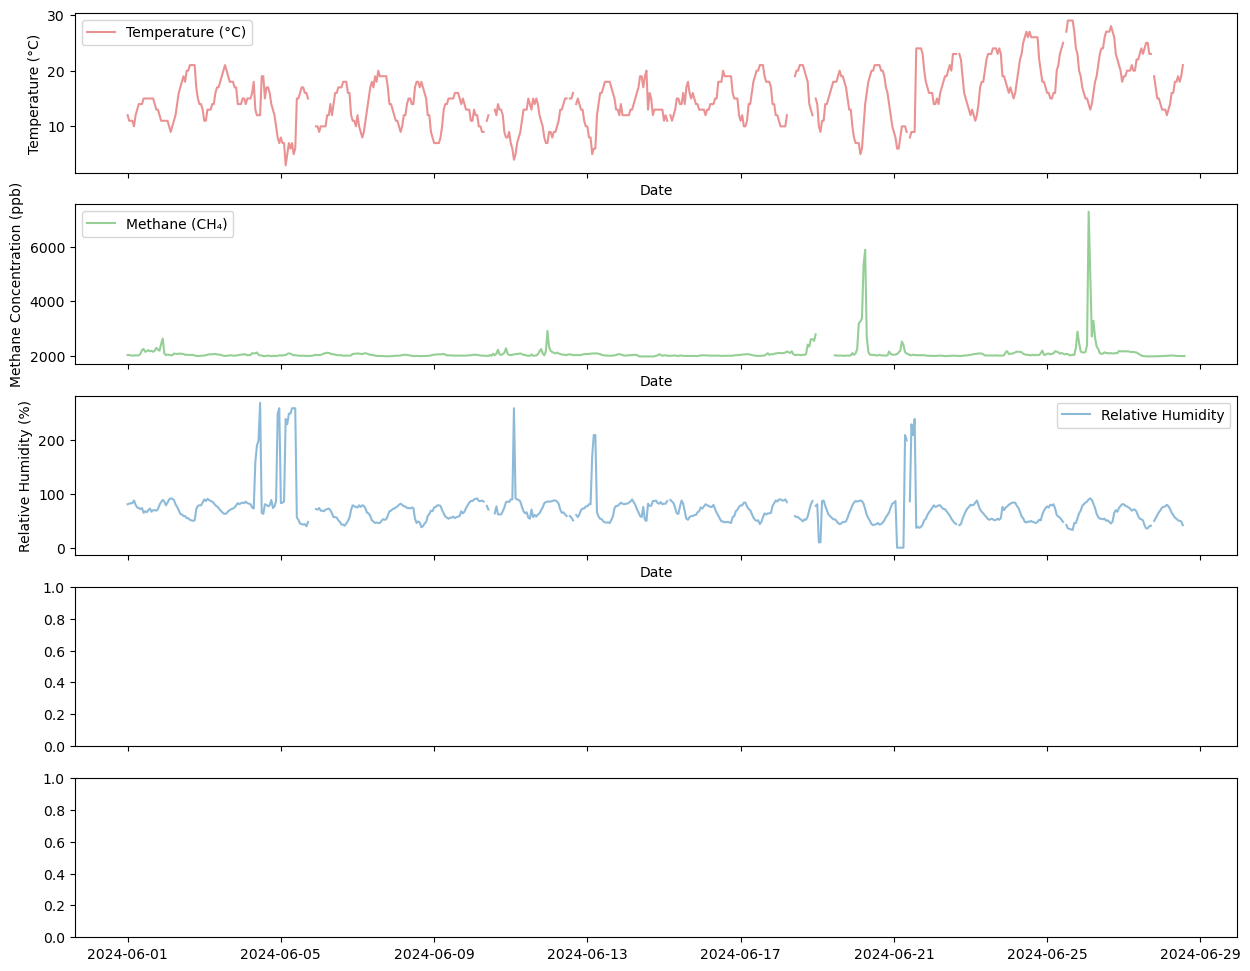

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from windrose import WindroseAxes

# Load the dataset
file_path = 'data/msr_ch4_met_hrly_310524_270924.csv'
try:
    data = pd.read_csv(file_path)

    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

    # Filter data to only include June and July 2024
    data = data[(data['date'] >= '2024-06-01') & (data['date'] <= '2024-07-01')]
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()
except pd.errors.EmptyDataError:
    print(f"Error: The file {file_path} is empty.")
    exit()
except pd.errors.ParserError:
    print(f"Error: The file {file_path} could not be parsed.")
    exit()

# Function to determine Pasquill-Gifford stability class
def determine_stability_class(row):
    hour = row['date'].hour
    wind_speed = row['ws']
    
    if 6 <= hour <= 18:  # Daytime hours (approx. 6 AM to 6 PM)
        if wind_speed < 2:
            return 'A'  # Very Unstable
        elif 2 <= wind_speed <= 5:
            return 'B'  # Moderately Unstable
        else:
            return 'C'  # Slightly Unstable
    else:  # Nighttime hours
        if wind_speed < 2:
            return 'F'  # Stable
        elif 2 <= wind_speed <= 5:
            return 'E'  # Slightly Stable
        else:
            return 'D'  # Neutral

# Apply the function to the dataframe
data['stability_class'] = data.apply(determine_stability_class, axis=1)

# Function to create individual time series subplots with rolling average
def plot_time_series_subplot(ax, x, y, ylabel, label, color, window):
    rolling_avg = y.ewm(span=window, adjust=False).mean()
    ax.plot(x, y, label=label, color=color, alpha=0.5)
    # ax.plot(x, rolling_avg, label=f'{label} (Smoothed Avg)', color='black', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['temp'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['rh'], 'Relative Humidity (%)', 'Relative Humidity', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], data['date'], data['modelCH4'], 'model', 'model', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'], stability_class_numeric, 'Stability Class', 'Stability Class', 'tab:cyan', window)

    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)

In [5]:
data = data[data['wd']%10 != 0]
print(data)

                   date  ALTM_hPa  temp  DEW_C     rh   wd    ws        nsec  \
104 2024-06-04 08:00:00      20.0  13.0   64.0  160.0  3.0  10.0  3926476800   
105 2024-06-04 09:00:00      19.0  12.0   64.0  190.0  9.0  10.0  3926480400   
106 2024-06-04 10:00:00      19.0  12.0   64.0  200.0  7.0  10.0  3926484000   
107 2024-06-04 11:00:00      18.0  12.0   68.0  270.0  7.0  10.0  3926487600   
118 2024-06-04 22:00:00       9.0   8.0   89.0  250.0  4.0  10.0  3926527200   
119 2024-06-04 23:00:00       9.0   7.0   89.0  260.0  4.0  10.0  3926530800   
123 2024-06-05 03:00:00       5.0   3.0   87.0  240.0  2.0  10.0  3926545200   
124 2024-06-05 04:00:00       7.0   5.0   87.0  230.0  4.0  10.0  3926548800   
125 2024-06-05 05:00:00      10.0   7.0   81.0  250.0  5.0  10.0  3926552400   
126 2024-06-05 06:00:00      11.0   6.0   72.0  250.0  3.0  10.0  3926556000   
127 2024-06-05 07:00:00      12.0   7.0   69.0  260.0  5.0  10.0  3926559600   
128 2024-06-05 08:00:00      12.0   5.0 

In [ ]:
import flux_model as model
from point_sampler import PointSampler
from geopy.distance import geodesic
import math
import numpy as np
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)
sampler = (0.144343, 52.237111)

sampler = tuple(reversed(sampler))
landfill = tuple(reversed(landfill))
sewage = reversed(sewage)


def get_relative_distances(source_location,sampler_location,wind_angle_deg):

        total_distance = geodesic(source_location,sampler_location).meters 
        sampler_bearing = get_bearing(source_location,sampler_location)

        downwind_distance = total_distance * np.cos((wind_angle_deg - sampler_bearing) * np.pi / 180)
        crosswind_distance = total_distance * np.sin((wind_angle_deg - sampler_bearing) * np.pi / 180) 

        return downwind_distance, crosswind_distance 

def get_bearing(source_location,sampler_location):
        pointA = sampler_location
        pointB = source_location

        lat1, lat2 = map(math.radians, [pointA[0], pointB[0]])
        diffLong = math.radians(pointB[1] - pointA[1])

        x = math.sin(diffLong) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(diffLong)

        initial_bearing = math.degrees(math.atan2(x, y))

        return (initial_bearing + 360) % 360

ls=10
downwind, crosswind = get_relative_distances(landfill,sampler,data['wd'])
downwind,crosswind,z = np.meshgrid(downwind,crosswind,10)
model.conc_line(1,data['ws'],downwind,crosswind,z,10,ls,0)


ValueError: operands could not be broadcast together with shapes (663,) (214812,) 

In [ ]:
import importlib
import sys 
# reload point sampler
from point_sampler import PointSampler
importlib.reload(sys.modules['point_sampler'])
from point_sampler import PointSampler 

In [ ]:
np.min(data['ch4_ppb'])

np.float64(1978.52419125)

In [ ]:
microsoft_sampler = PointSampler(sampler,10)
microsoft_sampler.add_source(landfill,500,10)
data['modelCH4'] = microsoft_sampler.sample_concentration(data['ws'],data['stability_class'],1,data['wd'])
print(data['modelCH4'][data['modelCH4']>10000000000])

65     3.041868e+10
71     2.709936e+10
72     2.709936e+10
73     2.709936e+10
95     2.709936e+10
           ...     
610    3.041868e+10
614    3.041868e+10
638    3.041868e+10
639    3.041868e+10
640    3.041868e+10
Name: modelCH4, Length: 86, dtype: float64


In [ ]:

def g_m3_to_ppm(methane_g_m3, temperature=273.15, pressure=101325):
    # T in K, P in Pa
    # Constants
    MOLAR_MASS_METHANE = 16.04  # g/mol for methane (CH4)
    R = 8.314  # J/(mol*K), ideal gas constant
    
    # Calculate the molar concentration of methane in mol/m^3
    molar_concentration = methane_g_m3 / MOLAR_MASS_METHANE  # mol/m^3
    
    # Calculate volume at specified conditions (temperature in Kelvin, pressure in Pascals)
    molar_volume = R * temperature / pressure #m^3/mol

    print(molar_volume)
    # Convert molar concentration to ppm
    
    ppm = molar_volume * molar_concentration * 1e6
    
    return ppm

data['modelPpb'] = g_m3_to_ppm(data['modelCH4']) *1e3 + 2000


0.022412722427831235


In [ ]:
data['emissionModel'] = (microsoft_sampler.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd']))
#data['emissionModel'][data['emissionModel']>1] = 0
# print(data['emissionModel'][data['emissionModel']<0])
data['reconstructedModel'] = (microsoft_sampler.sample_concentration(data['ws'],data['stability_class'],data['emissionModel'],data['wd']))

24     0.055071
25     0.056822
26     0.038577
27     0.031505
28     0.040628
         ...   
682    0.018765
683    0.017698
684    0.018919
685    0.014017
686    0.016200
Name: ch4_ppb, Length: 663, dtype: float64


0.022412722427831235


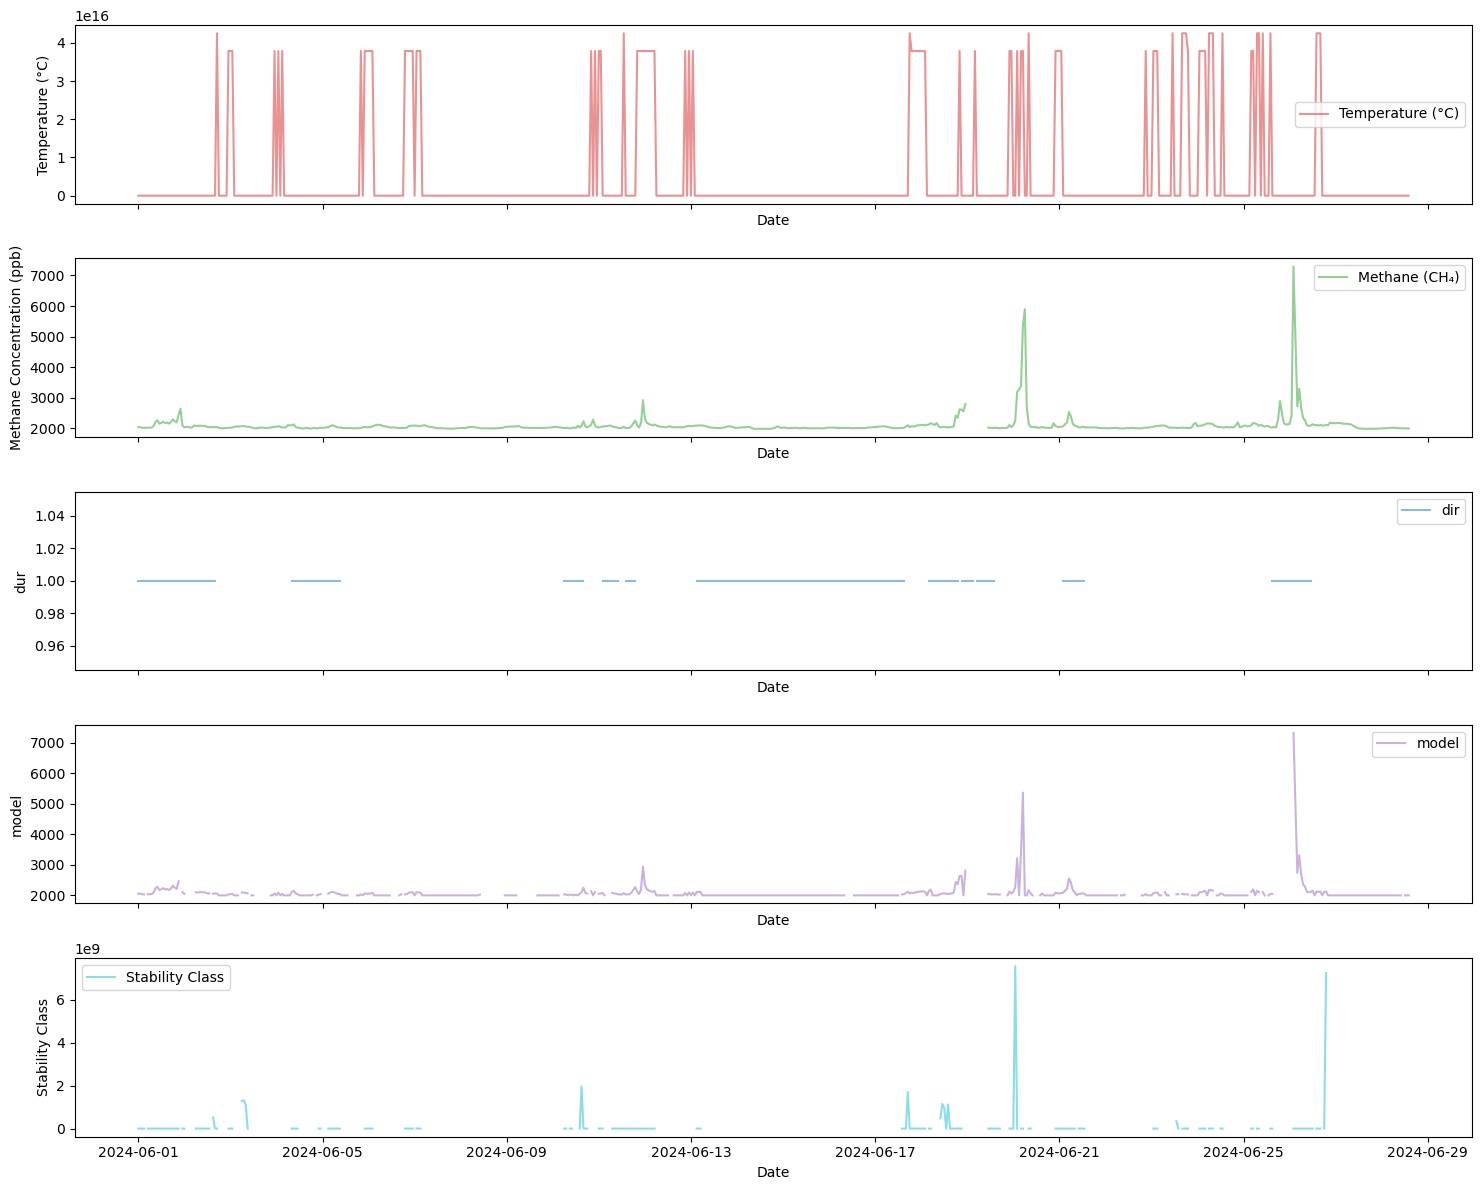

np.float64(340.0)

In [ ]:

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['modelPpb'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'][(data['wd']>330) | (data['wd']<30)], (data['wd']/data['wd'])[(data['wd']>330) | (data['wd']<30)], 'dur', 'dir', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], direction_filtered['date'], g_m3_to_ppm(direction_filtered['reconstructedPp,  'model', 'model', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'],data['emissionModel'], 'Stability Class', 'Stability Class', 'tab:cyan', window)


    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)
data['wd'][np.argmax(data['modelCH4'])]

24     0.055071
25     0.056822
26     0.038577
27     0.031505
28     0.040628
         ...   
682    0.018765
683    0.017698
684    0.018919
685    0.014017
686    0.016200
Name: ch4_ppb, Length: 663, dtype: float64


KeyError: 'emissionModel'

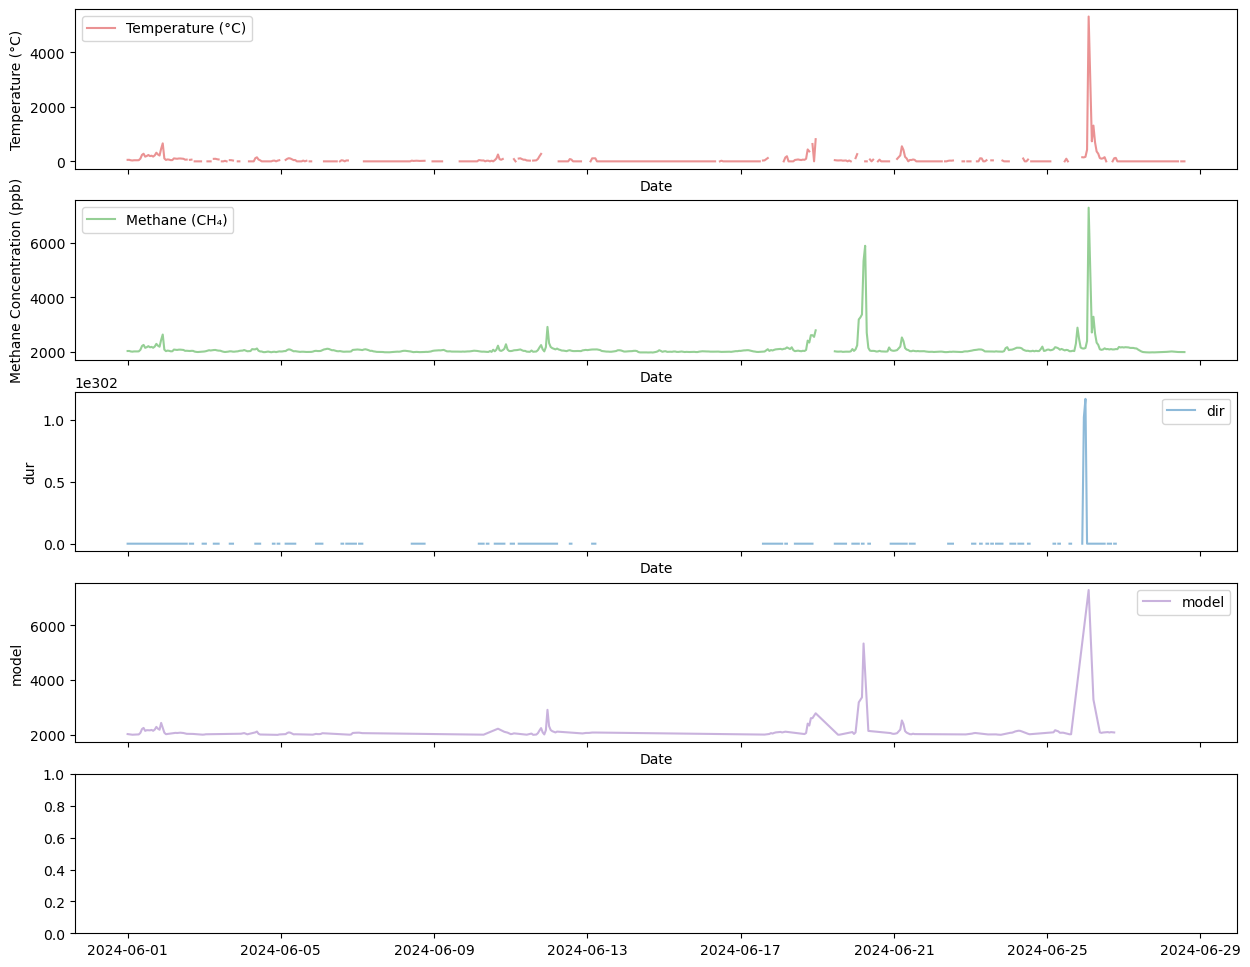

In [282]:
singlePoint = PointSampler(sampler,10)
singlePoint.add_source(landfill,0,10)
data['emissionPoint'] = (singlePoint.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd']))
data['reconstructedPoint'] = 1e3 * singlePoint.g_m3_to_ppm((singlePoint.sample_concentration(data['ws'],data['stability_class'],data['emissionPoint'],data['wd'])))

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['reconstructedPoint'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['emissionPoint'],'dur', 'dir', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], direction_filtered['date'], direction_filtered['reconPpb'], 'model', 'model', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'],data['emissionModel'], 'Stability Class', 'Stability Class', 'tab:cyan', window)

    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)
data['wd'][np.argmax(data['modelCH4'])]

np.min(data['ch4_ppb'])
print(np.max(data['emissionModel']))
data['wd'][np.argmax(data['emissionModel'])]
print(f'{np.min(data['emissionModel'])=}')
noNans = data['emissionModel'][~np.isnan(data['emissionModel'])]
print(f'{np.average(noNans)=}')
print(np.argmin(data['emissionModel']))
print(data['modelCH4'][np.argmin(data['emissionModel'])])


In [ ]:
maxline = data[data['emissionModel'] == np.max(data['emissionModel'])]
print(maxline)

                   date  ALTM_hPa  temp  DEW_C    rh    wd   ws        nsec  \
481 2024-06-20 01:00:00    1021.7   7.0    5.0  86.0  30.0  2.0  3927834000   

       lat   lon  ...  latitude2  longitude2  stability_class      modelCH4  \
481  52.42  0.57  ...  52.237111    0.144343                E  2.501462e-14   

     modelPpb  emissionModel  reconstructedModel  emissionPoint  \
481    2000.0   7.568082e+09            0.000189   8.570114e+36   

    reconstructedPoint    downwind  
481         264.526943  831.278378  

[1 rows x 26 columns]


0.029129933042606936
                   date  ALTM_hPa  temp  DEW_C    rh     wd   ws        nsec  \
63  2024-06-02 15:00:00    1024.1  21.0   11.0  52.0  300.0  2.0  3926329200   
78  2024-06-03 06:00:00    1021.3  14.0   11.0  83.0  300.0  3.0  3926383200   
79  2024-06-03 07:00:00    1021.0  16.0   12.0  79.0  300.0  3.0  3926386800   
80  2024-06-03 08:00:00    1021.0  17.0   13.0  77.0  300.0  3.0  3926390400   
161 2024-06-06 17:00:00    1016.3  18.0    6.0  45.0  300.0  3.0  3926682000   
202 2024-06-08 10:00:00    1010.8  14.0    9.0  75.0  300.0  5.0  3926829600   
255 2024-06-10 15:00:00    1012.2  12.0    9.0  77.0  300.0  4.0  3927020400   
425 2024-06-17 17:00:00    1010.8  18.0   11.0  64.0  300.0  3.0  3927632400   
442 2024-06-18 10:00:00    1013.6  19.0   11.0  59.0  300.0  2.0  3927693600   
443 2024-06-18 11:00:00    1013.6  20.0   11.0  57.0  300.0  4.0  3927697200   
444 2024-06-18 12:00:00    1013.6  20.0   11.0  57.0  300.0  3.0  3927700800   
446 2024-06-18 14:0

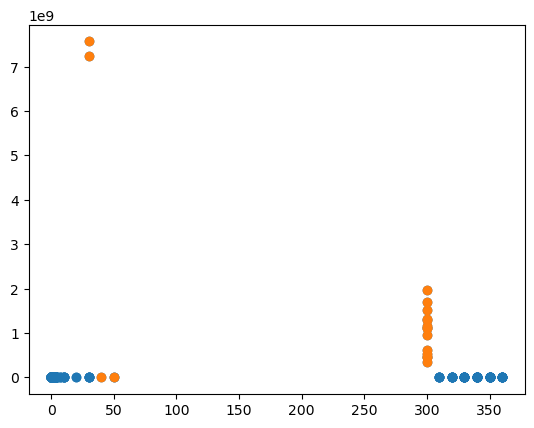

300.0


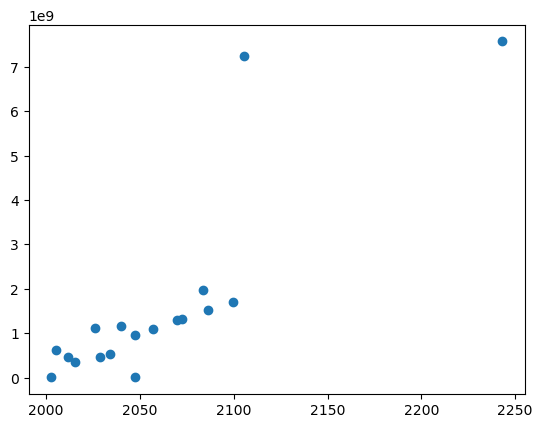

In [ ]:
data['downwind'] = microsoft_sampler.get_relative_distances(data['wd'])[0]
print(np.nanmedian(data['emissionModel']))

filtered = data[data['emissionModel']>1000000]
print(filtered)
print(len(filtered))

plt.scatter(data['wd'],data['emissionModel'])

plt.scatter(filtered['wd'],filtered['emissionModel'])
plt.show()
plt.scatter(filtered['ch4_ppb'],filtered['emissionModel'])

print(np.nanmax(filtered['wd']))


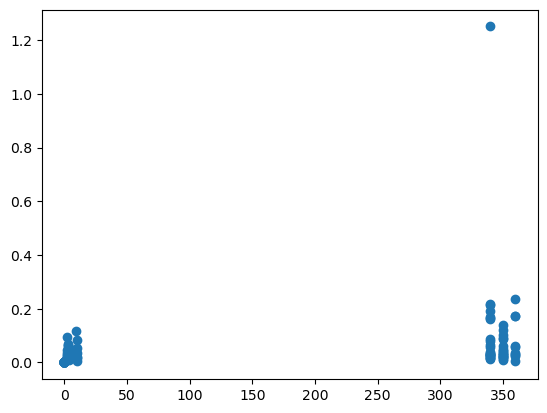

In [ ]:
direction_filtered = data[(data['wd']>335) | (data['wd']<20)]
plt.scatter(direction_filtered['wd'],direction_filtered['emissionModel'])   

7250324847.236317
                   date  ALTM_hPa  temp  DEW_C    rh    wd   ws        nsec  \
481 2024-06-20 01:00:00    1021.7   7.0    5.0  86.0  30.0  2.0  3927834000   

       lat   lon  ...  latitude2  longitude2  stability_class      modelCH4  \
481  52.42  0.57  ...  52.237111    0.144343                E  2.501462e-14   

     modelPpb  emissionModel  reconstructedModel  emissionPoint  \
481    2000.0   7.568082e+09            0.000189   8.570114e+36   

    reconstructedPoint    downwind  
481         264.526943  831.278378  

[1 rows x 26 columns]


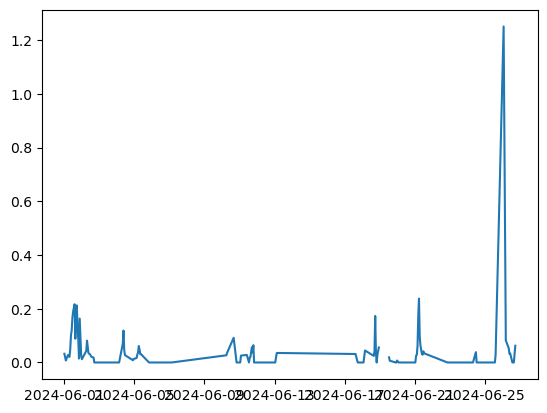

In [ ]:
microsoft_sampler.get_bearing()
plt.plot(direction_filtered['date'],direction_filtered['emissionModel'])
plt.plot(direction_filtered['date'],reconstructedFiltered/np.max(reconstructedFiltered))

noNans = data['emissionModel'][~np.isnan(data['emissionModel'])]
print(sorted(noNans)[-2])
maxcon = data[sorted(noNans)[-1] == data['emissionModel']]
print(maxcon)

0.022412722427831235


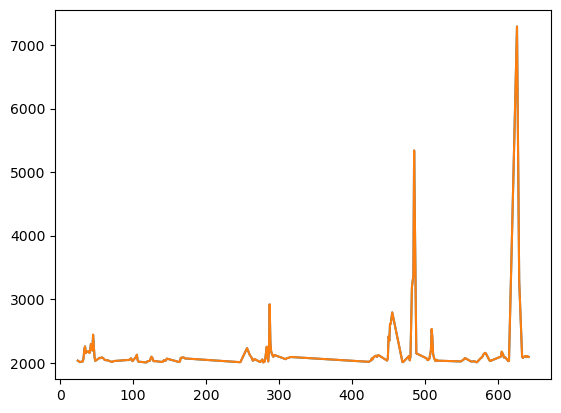

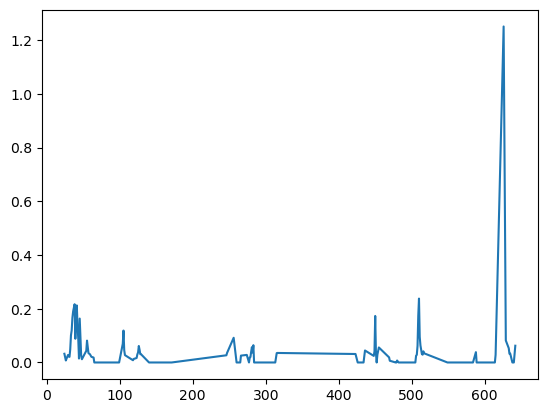

In [ ]:

direction_filtered['reconstructedFiltered']= microsoft_sampler.sample_concentration(direction_filtered['ws'],direction_filtered['stability_class'],direction_filtered['emissionModel'],direction_filtered['wd'])
direction_filtered['reconPpb'] = g_m3_to_ppm(direction_filtered['reconstructedFiltered'])*1e3 + 1978
plt.plot(direction_filtered['reconPpb'])
plt.plot(direction_filtered['ch4_ppb'])
direction_filtered = direction_filtered[~np.isnan(direction_filtered['reconPpb'])]
np.corrcoef(direction_filtered['reconPpb'],direction_filtered['ch4_ppb'])
plt.show()
plt.plot(direction_filtered['emissionModel'])